**TABLA DE CONTENINDOS**
- 1.- Preparar los datos
 - 1.1  Abrir archivos y examinar los datos
 - 1.2  Comprobar que el cálculo de la recuperación sea correcto. Calcular la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento. Encontrar el EAM entre los cálculos y los valores de la característica. Facilitar los resultados.
 - 1.3  Analizar las características no disponibles en el conjunto de prueba. ¿Cuáles son estos parámetros? ¿Cuál es su tipo?
 - 1.4  Realizar el preprocesamiento de datos
- 2  Analiza los datos
 - 2.1  Observar cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.
 - 2.2  Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.
- 3 Construir el modelo
 - 3.1  Escribe una función para calcular el valor final de sMAPE.
 - 3.2  Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba. Facilita los resultados.
- 4 Conclusión general

## Preparar datos

### Abrir archivos y examinar los datos

In [ ]:
# Importamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from scipy.stats import ttest_ind

# Mostrar hasta 100 columnas
pd.set_option("display.max_columns", 100)

In [ ]:
# Cargamos los DataFrames

train_df = pd.read_csv("/datasets/gold_recovery_train.csv")
test_df = pd.read_csv("/datasets/gold_recovery_test.csv")
full_df = pd.read_csv("/datasets/gold_recovery_full.csv")

Visualizamos las tres tablas y su información general.

In [ ]:
# Revisamos train
train_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [ ]:
# Revisamos información general de train
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


2.- **Estudiamos test**

In [ ]:
# Revisamos test
test_df.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [ ]:
# Revisamos información general de train
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

3.- **Estudiamos full**

In [ ]:
# Revisamos full
full_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [ ]:
# Revisamos información general de full
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [ ]:
# Revisamos el número de columnas y filas de los DF

print(train_df.shape)
print(test_df.shape)
print(full_df.shape)

(16860, 87)
(5856, 53)
(22716, 87)


- 1. Los tres DataFrames difieren en número de variables y muestras
- 2. El conjunto de prueba posee menos características
- 3. Podemos ver valores nulos que veremos en más detalle más adelante

### Comprobar que el cálculo de la recuperación sea correcto. Calcular la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento. Encontrar el EAM entre los cálculos y los valores de la característica. Facilitar los resultados.


In [ ]:
## Fórmula

# Rougher:
# Cr = rougher.output.concentrate_au
# Fr = rougher.input.feed_au
# Tr = rougher.output.tail_au

# recovery = Cr * (Fr - Tr) / (Fr * (Cr - Tr))
# recovery_rougher = rougher.output.recovery

# mean_absolute_error(recovery_rougher, recovery)

# Final:
# Cf = final.output.concentrate_au
# Ff = rougher.output.concentrate_au
# Tf = final.tail_au

In [ ]:
# Calculamos la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento

Cr = train_df["rougher.output.concentrate_au"]
Fr = train_df["rougher.input.feed_au"]
Tr = train_df["rougher.output.tail_au"]

# Guardamos los valores en la variable recovery_check_rougher

recovery_check_rougher = ((Cr * (Fr - Tr)) / (Fr * (Cr - Tr))) * 100

In [ ]:
# En esta otra variable guardaremos los valores originales de recuperación

df_recovery_rougher = train_df["rougher.output.recovery"]

In [ ]:
# Calculamos el MAE
mae = np.mean(np.abs(recovery_check_rougher - df_recovery_rougher))
mae

9.303415616264301e-15

- En este caso el mae es un valor extremadamente pequeño, lo que nos indica que el cálculo está correcto.
- Este valor es practicamente un cero.

Además mostraremos ambas tablas para comprobar esto.

In [ ]:
# Resultados por medio de las formulas
recovery_check_rougher.head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

In [ ]:
# Resultados de la tabla original
train_df["rougher.output.recovery"].head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

Como podemos observar, los valores son idénticos!

### Analizar las características no disponibles en el conjunto de prueba. ¿Cuáles son estos parámetros? ¿Cuál es su tipo?

In [ ]:
# Mostramos las características faltantes en el conjunto de prueba

missing_features = set(train_df.columns) - set(test_df.columns)
missing_features, len(missing_features)

({'final.output.concentrate_ag',
  'final.output.concentrate_au',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol',
  'final.output.recovery',
  'final.output.tail_ag',
  'final.output.tail_au',
  'final.output.tail_pb',
  'final.output.tail_sol',
  'primary_cleaner.output.concentrate_ag',
  'primary_cleaner.output.concentrate_au',
  'primary_cleaner.output.concentrate_pb',
  'primary_cleaner.output.concentrate_sol',
  'primary_cleaner.output.tail_ag',
  'primary_cleaner.output.tail_au',
  'primary_cleaner.output.tail_pb',
  'primary_cleaner.output.tail_sol',
  'rougher.calculation.au_pb_ratio',
  'rougher.calculation.floatbank10_sulfate_to_au_feed',
  'rougher.calculation.floatbank11_sulfate_to_au_feed',
  'rougher.calculation.sulfate_to_au_concentrate',
  'rougher.output.concentrate_ag',
  'rougher.output.concentrate_au',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol',
  'rougher.output.recovery',
  'rougher.output.tail_ag',
  'rougher.output.t

En este caso lo que haremos es volver a separar el conjunto de entrenamiento y el de prueba para que tengan las mismas columnas.

In [ ]:
# Separamos en conjunto de entrenamiento y de prueba
## El tamaño del conjunto de prueba será de 0.25
train_df_v2, test_df_v2 = train_test_split(full_df, test_size=0.25, random_state=42)

In [ ]:
train_df_v2.shape, test_df_v2.shape

((17037, 87), (5679, 87))

**Ahora el conjunto de entrenamiento posee las misma cantidad de columnas que el conjunto de prueba!**
Esto nos evitará problemas al momento de entrenar nuestro modelo.

### Realizar el preprocesamiento de datos

1. Revisaremos valores nulos
2. Revisaremos duplicados
3. Revisaremos los formatos de las columnas

- 1. Revisamos y abordamos valores nulos

In [ ]:
# Revisamos valores ausentes de train
isna_train_df_v2 = train_df_v2.isna().sum().sum()
total_train_df_v2 = len(train_df_v2) * len(train_df_v2.columns)
print(f"Valores ausentes de train_df_v2: {(isna_train_df_v2 / total_train_df_v2) * 100}%")

Valores ausentes de train_df_v2: 1.8719905762913578%


In [ ]:
# Revisamos valores ausentes de test
isna_test_df_v2 = test_df_v2.isna().sum().sum()
total_test_df_v2 = len(test_df_v2) * len(test_df_v2.columns)
print(f"Valores ausentes de test_df: {((isna_test_df_v2 / total_test_df_v2) * 100)}%")

Valores ausentes de test_df: 1.7892092868867555%


In [ ]:
# Revisamos valores ausentes de full
isna_full_df = full_df.isna().sum().sum()
total_full_df = len(full_df) * len(full_df.columns)
print(f"Valores ausentes de full_df: {((isna_full_df / total_full_df) * 100)}%")

Valores ausentes de full_df: 1.851295253940207%


Como podemos ver, tenemos un porcentaje bajo de valores nulos en los tres DataFrames. Estos los imputaremos con los valores medianos de cada columna, de este modo las predicciones no se verán afectadas.

In [ ]:
# Imputamos los NaN de train_df_v2

# imputamos los NaN
train_df_v2.fillna(method='ffill', inplace=True)

# revisamos si hay NaN
train_df_v2.isna().sum().sum()


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


0

In [ ]:
# Imputamos los NaN de test_df_v2

# imputamos los NaN
test_df_v2.fillna(method='ffill', inplace=True)

# revisamos si hay NaN
test_df_v2.isna().sum().sum()

0

In [ ]:
# Imputamos los NaN de full_df

# imputamos los NaN
full_df.fillna(method='ffill', inplace=True)

# revisamos si hay NaN
full_df.isna().sum().sum()

0

- 2. Revisaremos y abordamos duplicados

In [ ]:
print(train_df_v2.duplicated().sum())
print(test_df_v2.duplicated().sum())
print(full_df.duplicated().sum())

0
0
0


No hay valores duplicados.

- 1. Las tres tablas tenían porcentajes de valores ausentes bastantes bajos (1.8% - 1.9%), que fueron imputados con las medianas de cada columna.
- 2. No se encontraron duplicados.
- 3. Al examinar los datos vimos que los formatos de las columnas están correctos.
- 4. Por otra parte, el formato de los nombres de las columnas es correcto.

## Analiza los datos

### Observar cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

1. Primero graficaremos las concentraciones totales del oro (Au) por cada etapa. Además graficaremos las distribuciones por medio de histogramas.

In [ ]:
# Función graficar histogramas

def hist_concentrates(dataframe, columns, title):
    plt.figure(figsize=(10, 6))
    for col in columns:
        dataframe[col].plot(kind='hist', bins=30, alpha=0.5)
    plt.legend(columns)
    plt.xlabel('Concentración')
    plt.ylabel('Frecuencia')
    plt.title(title)

In [ ]:
# Calculamos las concentraciones totales para la etapa de purificación de Au

r_input_au = full_df["rougher.input.feed_au"].sum()
r_output_au = full_df["rougher.output.concentrate_au"].sum()
p_cleaner_au = full_df["primary_cleaner.output.concentrate_au"].sum()
f_output_au = full_df["final.output.concentrate_au"].sum()

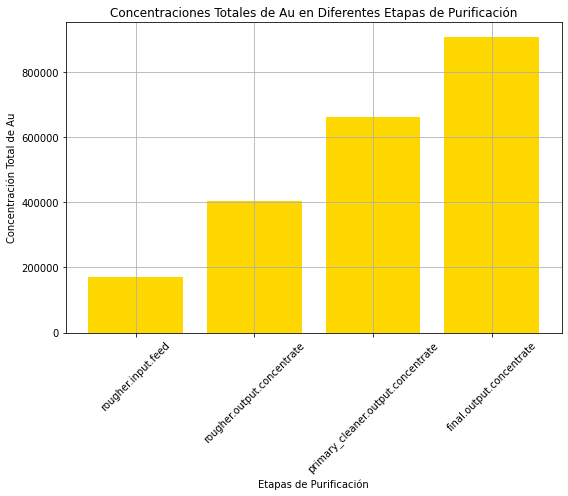

In [ ]:
# Graficamos las concentraciones de Au por etapa

etapas = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

concentraciones_au = [r_input_au, r_output_au, p_cleaner_au, f_output_au]

plt.figure(figsize=(8, 7))
plt.bar(etapas, concentraciones_au, color='gold')
plt.xlabel('Etapas de Purificación')
plt.ylabel('Concentración Total de Au')
plt.title('Concentraciones Totales de Au en Diferentes Etapas de Purificación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

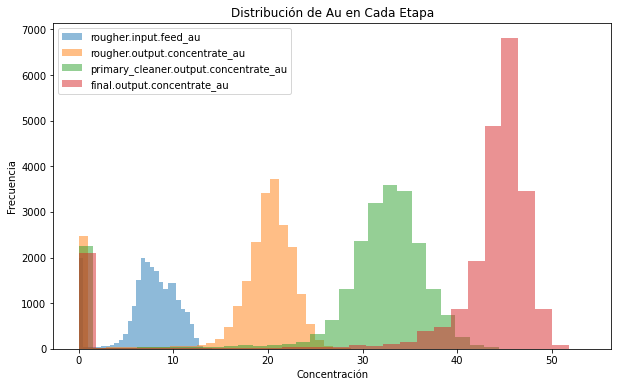

In [ ]:
# Graficamos distribuciones de Au por etapa

cols_au = ["rougher.input.feed_au", "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]
hist_concentrates(full_df, cols_au, "Distribución de Au en Cada Etapa")

2. Continuamos con las concentraciones totales de la plata (Ag)

In [ ]:
# Calculamos las concentraciones totales para la etapa de purificación de Ag

r_input_ag = full_df["rougher.input.feed_ag"].sum()
r_output_ag = full_df["rougher.output.concentrate_ag"].sum()
p_cleaner_ag = full_df["primary_cleaner.output.concentrate_ag"].sum()
f_output_ag = full_df["final.output.concentrate_ag"].sum()

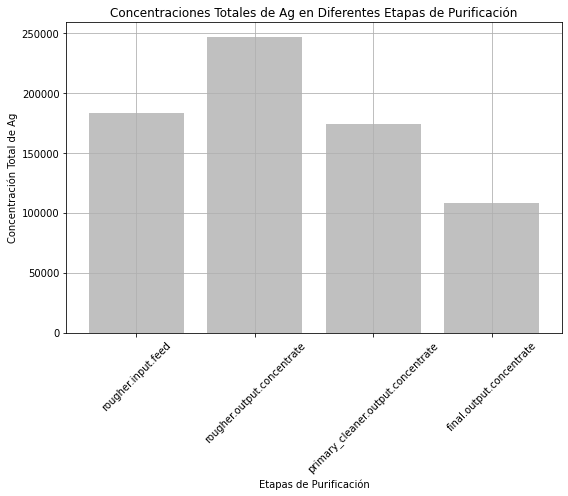

In [ ]:
# Graficamos las concentraciones de Ag por etapa

etapas = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

concentraciones_ag = [r_input_ag, r_output_ag, p_cleaner_ag, f_output_ag]

plt.figure(figsize=(8, 7))
plt.bar(etapas, concentraciones_ag, color='silver')
plt.xlabel('Etapas de Purificación')
plt.ylabel('Concentración Total de Ag')
plt.title('Concentraciones Totales de Ag en Diferentes Etapas de Purificación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

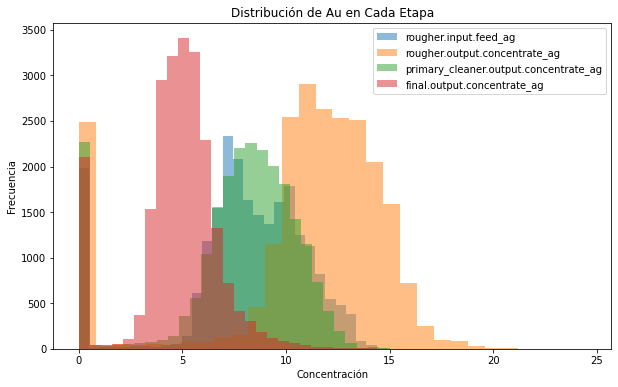

In [ ]:
# Graficamos distribuciones de Ag por etapa

cols_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
hist_concentrates(full_df, cols_ag, "Distribución de Au en Cada Etapa")

3. Continuamos con las concentraciones del plomo (Pb)

In [ ]:
# Calculamos las concentraciones totales para la etapa de purificación de Pb

r_input_pb = full_df["rougher.input.feed_pb"].sum()
r_output_pb = full_df["rougher.output.concentrate_pb"].sum()
p_cleaner_pb = full_df["primary_cleaner.output.concentrate_pb"].sum()
f_output_pb = full_df["final.output.concentrate_pb"].sum()

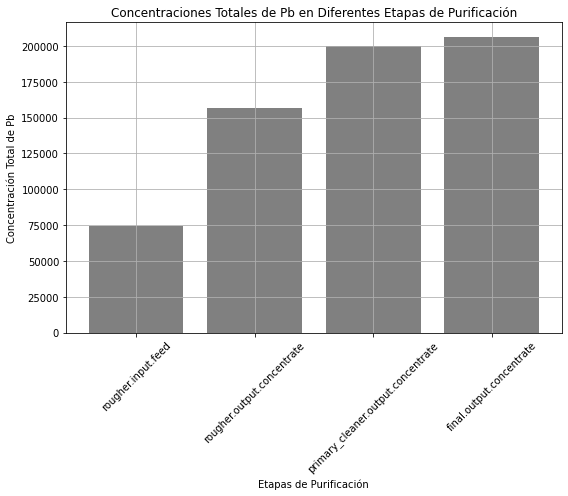

In [ ]:
# Graficamos las concentraciones de Pb por etapa

etapas = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

concentraciones_pb = [r_input_pb, r_output_pb, p_cleaner_pb, f_output_pb]

plt.figure(figsize=(8, 7))
plt.bar(etapas, concentraciones_pb, color='grey')
plt.xlabel('Etapas de Purificación')
plt.ylabel('Concentración Total de Pb')
plt.title('Concentraciones Totales de Pb en Diferentes Etapas de Purificación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

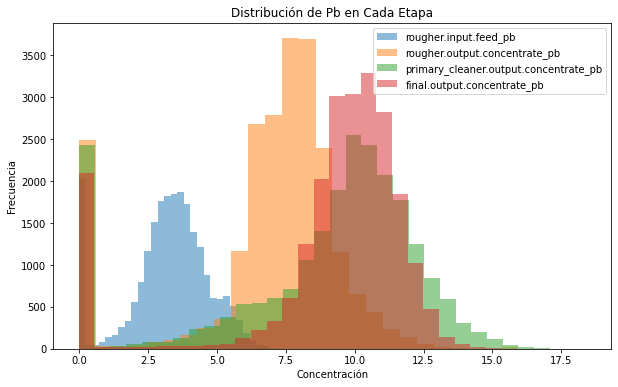

In [ ]:
# Graficamos distribuciones de Ag por etapa

cols_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
hist_concentrates(full_df, cols_pb, "Distribución de Pb en Cada Etapa")

Finalmente, sería interesante observar las concentraciones iniciales y finales de los metales.

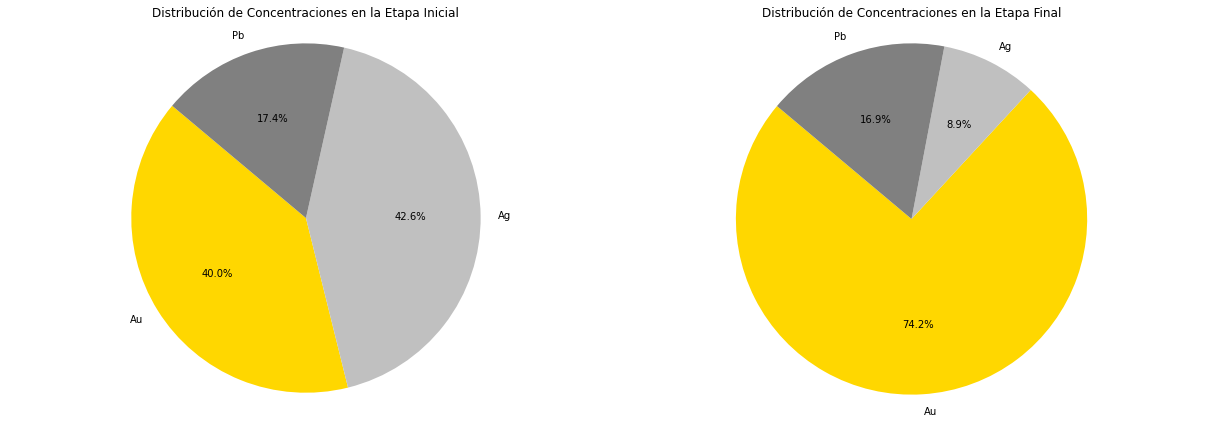

In [ ]:
# Graficamos concentraciones iniciales y finales del proceso de purificación

# Concentraciones iniciales

concentraciones_iniciales = [r_input_au, r_input_ag, r_input_pb]
metales = ['Au', 'Ag', 'Pb']
colores = ['gold', 'silver', 'gray']
plt.figure(figsize=(17, 6))

plt.subplot(1, 2, 1)
plt.pie(concentraciones_iniciales, labels=metales, colors=colores, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Concentraciones en la Etapa Inicial')
plt.axis('equal')

# Concentraciones finales
concentraciones_finales = [f_output_au, f_output_ag, f_output_pb]
plt.subplot(1, 2, 2)
plt.pie(concentraciones_finales, labels=metales, colors=colores, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Concentraciones en la Etapa Final')
plt.axis('equal')
plt.tight_layout()
plt.show()


- 1. En el caso de el oro las concentraciones totales van en aumento durante todo el proceso. Su concentración final supera los 800.000.
- 2. En cuanto al la plata, su concentración sube, pero luego baja, quedando en una concentración final que apenas supera los 100.000.
- 3. Las concentraciones de plomo aumentan en cada etapa, resultando en una concentración total final que supera los 200.000.
- 4. Por medio de los histogramas también podemos ver como van aumentando las concentraciones de los metales en cada etapa.
- 5. El gráfico circular indica un claro aumento de la concentración del oro, mientras que la plata es el metal que más disminuye.

### Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

Primero compararemos las distribuciones de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba por medio de gráficos de boxplot.

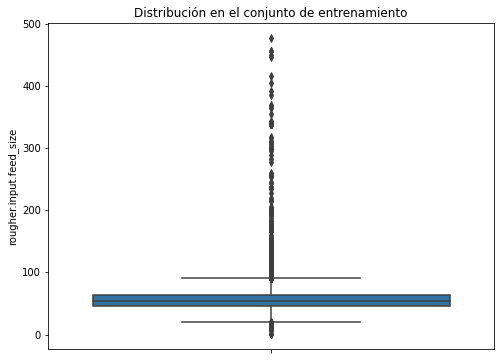

In [ ]:
# Distribución en el conjunto de entrenamiento

plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df_v2, y="rougher.input.feed_size")
plt.title("Distribución en el conjunto de entrenamiento")
plt.show()

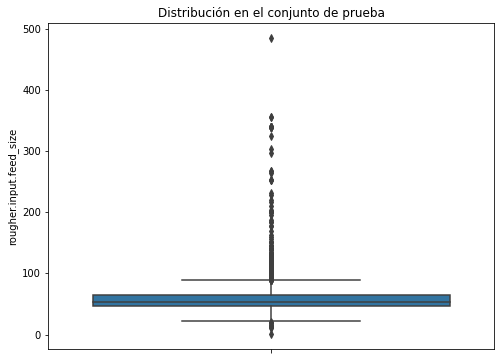

In [ ]:
# Distribución en el conjunto de prueba

plt.figure(figsize=(8, 6))
sns.boxplot(data=test_df_v2, y="rougher.input.feed_size")
plt.title("Distribución en el conjunto de prueba")
plt.show()

En ambos casos la distribución se ve bastante similar.

Ahora veremos la distribución por medio de histogramas.

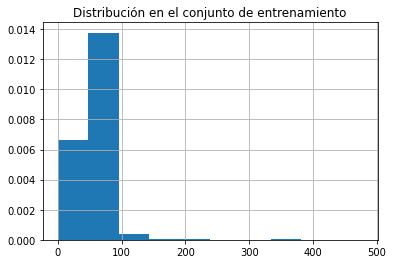

In [ ]:
# Distribución en el conjunto de entrenamiento

train_df_v2["rougher.input.feed_size"].hist(density=True)
plt.title("Distribución en el conjunto de entrenamiento")
plt.show()

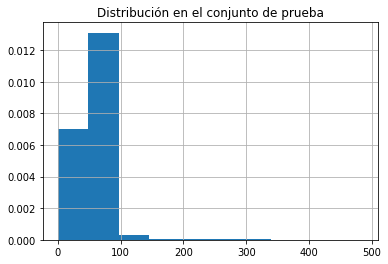

In [ ]:
# Distribución en el conjunto de prueba

test_df_v2["rougher.input.feed_size"].hist(density=True)
plt.title("Distribución en el conjunto de prueba")
plt.show()

En los histogramas podemos ver que la distribución varía ligeramente.

Por último, llevaremos a cabo un test estadístico de diferencia de medias.

In [ ]:
# Aplicamos un t-test

train_s = train_df_v2["rougher.input.feed_size"]
test_s = test_df_v2["rougher.input.feed_size"]

t_statistic, p_value = ttest_ind(train_s, test_s)


print("Valor de p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay evidencia de diferencia en las medias.")
else:
    print("No hay suficiente evidencia para rechazar la hipótesis nula. Las medias son similares.")

Valor de p: 0.7844763915407349
No hay suficiente evidencia para rechazar la hipótesis nula. Las medias son similares.


De acuerdo al test, las medias son similares. De este modo, no deberíamos tener problemas con la evaluación de nuestros modelos.

### Considera las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. ¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? Describe los resultados y elimina las anomalías.

1. Primero sumaremos las concentraciones del conjunto de entrenamiento

In [ ]:
# Etapa materia prima
train_df_v2["rougher_input_total"] = train_df_v2[["rougher.input.feed_au", "rougher.input.feed_ag", "rougher.input.feed_pb"]].sum(axis=1)

# Etapa concentrado rougher
train_df_v2["rougher_output_total"] = train_df_v2[["rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb"]].sum(axis=1)

#b Etapa concentrado final
train_df_v2["final_output_total"] = train_df_v2[["final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb"]].sum(axis=1)


/tmp/ipykernel_367/323964249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_v2["rougher_input_total"] = train_df_v2[["rougher.input.feed_au", "rougher.input.feed_ag", "rougher.input.feed_pb"]].sum(axis=1)
/tmp/ipykernel_367/323964249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_v2["rougher_output_total"] = train_df_v2[["rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb"]].sum(axis=1)
/tmp/ipykernel_367/323964249.py:8: SettingWithCop

2. Luego sumaremos las concentraciones del conjunto de prueba

In [ ]:
# Etapa materia prima
test_df_v2["rougher_input_total"] = test_df_v2[["rougher.input.feed_au", "rougher.input.feed_ag", "rougher.input.feed_pb"]].sum(axis=1)

# Etapa concentrado rougher
test_df_v2["rougher_output_total"] = test_df_v2[["rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb"]].sum(axis=1)

# Etapa concentrado final
test_df_v2["final_output_total"] = test_df_v2[["final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb"]].sum(axis=1)


/tmp/ipykernel_367/526894995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_v2["rougher_input_total"] = test_df_v2[["rougher.input.feed_au", "rougher.input.feed_ag", "rougher.input.feed_pb"]].sum(axis=1)
/tmp/ipykernel_367/526894995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_v2["rougher_output_total"] = test_df_v2[["rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb"]].sum(axis=1)
/tmp/ipykernel_367/526894995.py:8: SettingWithCopyWar

Graficamos las concentraciones totales del conjunto de **prueba**.

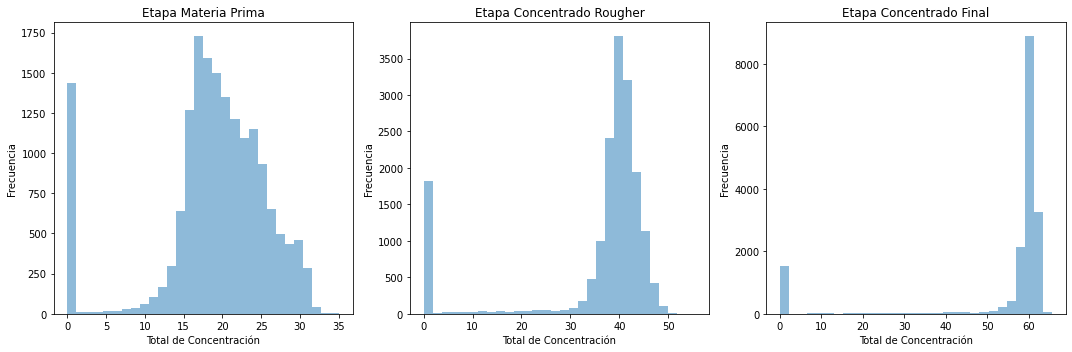

In [ ]:
# Histograma de Etapa materia prima
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(train_df_v2["rougher_input_total"], bins=30, alpha=0.5)
axs[0].set_title("Etapa Materia Prima")
axs[0].set_xlabel("Total de Concentración")
axs[0].set_ylabel("Frecuencia")

# Histograma de Etapa concentrado rougher
axs[1].hist(train_df_v2["rougher_output_total"], bins=30, alpha=0.5)
axs[1].set_title("Etapa Concentrado Rougher")
axs[1].set_xlabel("Total de Concentración")
axs[1].set_ylabel("Frecuencia")

# Histograma de Etapa concentrado final
axs[2].hist(train_df_v2["final_output_total"], bins=30, alpha=0.5)
axs[2].set_title("Etapa Concentrado Final")
axs[2].set_xlabel("Total de Concentración")
axs[2].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


Graficamos las concentraciones totales del conjunto de **entrenamiento**.

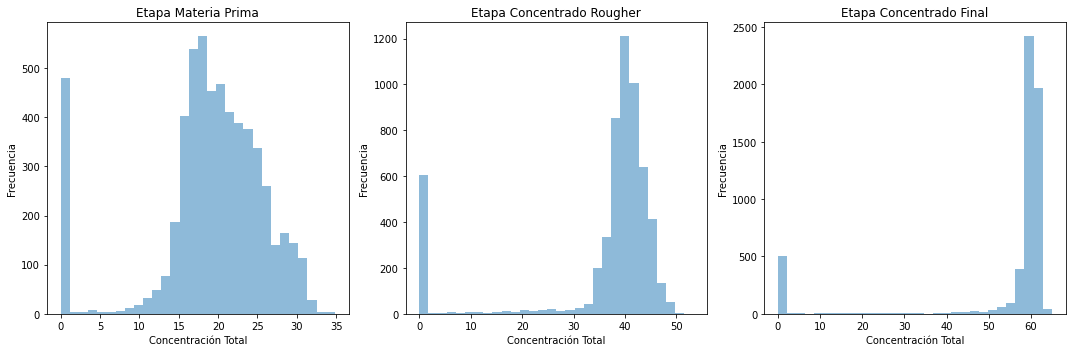

In [ ]:
# Histograma de Etapa materia prima
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(test_df_v2["rougher_input_total"], bins=30, alpha=0.5)
axs[0].set_title("Etapa Materia Prima")
axs[0].set_xlabel("Concentración Total")
axs[0].set_ylabel("Frecuencia")

# Histograma de Etapa concentrado rougher
axs[1].hist(test_df_v2["rougher_output_total"], bins=30, alpha=0.5)
axs[1].set_title("Etapa Concentrado Rougher")
axs[1].set_xlabel("Concentración Total")
axs[1].set_ylabel("Frecuencia")

# Histograma de Etapa concentrado final
axs[2].hist(test_df_v2["final_output_total"], bins=30, alpha=0.5)
axs[2].set_title("Etapa Concentrado Final")
axs[2].set_xlabel("Concentración Total")
axs[2].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


1. Al observar las distribuciones en ambas muestras, estas se ven bastante parecidas.
2. Como podemos observar, el concentrado en cada etapa va aumentando, lo que tiene sentido, ya que estamos analizando un proceso de purificación.
3. Por otro lado podemos ver donde se acumulan las concentraciones (moda).

## Construir el modelo

Primero estableceremos las características y las variables objetivo.

In [ ]:
# Separar el conjunto de entrenamiento en características y objetivos
X_train = train_df_v2.drop(["rougher.output.recovery", "final.output.recovery", "date"], axis=1)
y_train_rougher = train_df_v2["rougher.output.recovery"]
y_train_final = train_df_v2["final.output.recovery"]

# Separar el conjunto de prueba en características y objetivos
X_test = test_df_v2.drop(["rougher.output.recovery", "final.output.recovery", "date"], axis=1)
y_test_rougher = test_df_v2["rougher.output.recovery"]
y_test_final = test_df_v2["final.output.recovery"]

### Escribe una función para calcular el valor final de sMAPE.

In [ ]:
# Función sMAPE

def smape_(y, y_pred):

    n = len(y)
    abs_y = np.abs(y)
    abs_y_pred = np.abs(y_pred)
    abs_diff = np.abs(y - y_pred)

# Evitar divisiones por cero
    denominator = abs_y + abs_y_pred
    denominator[denominator == 0] = 1e-10

    return 100 * (2 / n) * np.nansum(abs_diff / (abs_y + abs_y_pred))

# Función sMAPE final

def smape_final(y, y_pred):

    pred_target_1 = y_pred[:, 0]
    pred_target_2 = y_pred[:, 1]

    rougher_smape = smape_(y[:, 0], pred_target_1)
    final_smape = smape_(y[:, 1], pred_target_2)

    return 0.25 * rougher_smape + 0.75 * final_smape



### Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba. Facilita los resultados.

Entrenaremos **UN** modelo para ambas variables. En este caso Linear Regression.

In [ ]:
# Aquí entrenaremos nuestro modelo con ambas variables objetivo: 'rougher.output.recovery' y 'final.output.recovery'

lr_multitarget = LinearRegression()
y_train_multivariable = np.column_stack((y_train_rougher, y_train_final))
lr_multitarget.fit(X_train, y_train_multivariable)

LinearRegression()

In [ ]:
# Guardamos las predicciones

predictions_multitarget = lr_multitarget.predict(X_test)

In [ ]:
# smape_scorer será nuestra métrica de evaluación

smape_scorer = make_scorer(smape_final, greater_is_better=False)

In [ ]:
# Llevamos a cabo nuestro proceso de validación cruzada

cv_results = cross_validate(
    lr_multitarget,
    X_train,
    y_train_multivariable,
    cv=3,
    scoring=smape_scorer
)

#  Invertimos los valores multiplicándo por -1
cv_scores = -1 * cv_results['test_score']

mean_smape = np.mean(cv_scores)
std_smape = np.std(cv_scores)

print("Promedio sMAPE:", mean_smape)

Promedio sMAPE: 7.759502201474085


En este caso nuestro sMAPE es 7.759404

Por otra parte, Linear Regression no tiene hiperparámetros, por lo que entrenaremos un modelo Ridge buscando el mejor parámetro **'alpha'** con un loop. Además ajustaremos las características con StandardScaler() para evitar errores.

In [ ]:
# Entrenamos Ridge()
ridge_model = Ridge()

# Rango de parámetros
alphas = np.logspace(-6, 6, 13)

smape_scorer = make_scorer(smape_final, greater_is_better=False)

# Normalizamos las características para educir la colinealidad
scaler = StandardScaler()

cv_scores = []

for alpha in alphas:
    ridge_model.alpha = alpha
    X_train_scaled = scaler.fit_transform(X_train)
    cv_results = cross_validate(
        ridge_model,
        X_train_scaled,
        y_train_multivariable,
        cv=3,
        scoring=smape_scorer
    )
    cv_score = -np.mean(cv_results['test_score'])
    cv_scores.append(cv_score)
    print(f"Alpha: {alpha:.6f}, Promedio sMAPE: {cv_score:.6f}")

# Encontramos el valor de alpha con el menor sMAPE
best_alpha = alphas[np.argmin(cv_scores)]

print(f"Mejor valor de alpha: {best_alpha:.6f}")

Alpha: 0.000001, Promedio sMAPE: 7.759404
Alpha: 0.000010, Promedio sMAPE: 7.759404
Alpha: 0.000100, Promedio sMAPE: 7.759404
Alpha: 0.001000, Promedio sMAPE: 7.759403
Alpha: 0.010000, Promedio sMAPE: 7.759396
Alpha: 0.100000, Promedio sMAPE: 7.759323
Alpha: 1.000000, Promedio sMAPE: 7.758618
Alpha: 10.000000, Promedio sMAPE: 7.753518
Alpha: 100.000000, Promedio sMAPE: 7.794196
Alpha: 1000.000000, Promedio sMAPE: 8.188355
Alpha: 10000.000000, Promedio sMAPE: 9.029523
Alpha: 100000.000000, Promedio sMAPE: 10.778545
Alpha: 1000000.000000, Promedio sMAPE: 11.612960
Mejor valor de alpha: 10.000000


- En este caso entrenamos 13 modelos, donde el parámetro alpha: 10.000000 nos dió el sMAPE más bajo (7.753561). **Un valor ligeramente más bajo que el que nos dio Linear Regression (7.759404)**.

A continuación probaremos nuestro mejor modelo con el conjunto de prueba!

In [ ]:
# Primero guardamos nuestras dos variables objetivo
y_test_multivariable = np.column_stack((y_test_rougher, y_test_final))

In [ ]:
# Entrenamos Ridge() en el conjunto de entrenamiento
ridge_model = Ridge(alpha=best_alpha)

# Normalizamos las características para reducir la colinealidad
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model.fit(X_train_scaled, y_train_multivariable)
predictions_test = ridge_model.predict(X_test_scaled)
smape_test = smape_final(y_test_multivariable, predictions_test)

print("SMAPE en el conjunto de prueba:", smape_test)


SMAPE en el conjunto de prueba: 7.542329034108532


- Al uttilizar nuestro modelo Ridge en el conjunto de prueba, el valor sMAPE es ligeramente menor.

## Conclusión general

- 1. Al examinar los datos:
 - Los tres DataFrames difieren en número de variables y muestras
 - El conjunto de prueba posee menos características
 - Encontramos valores nulos


- 2. Al comprobar el cálculo de recuperación:
 - En este caso el mae es un valor extremadamente pequeño, lo que nos indica que el cálculo está correcto.
 - Este valor es practicamente un cero.


- 3. AL realizar el procesamiento de datos
 - Las tres tablas tenían porcentajes de valores ausentes bastantes bajos (1.8% - 1.9%), que fueron imputados con las medianas de cada columna.
 - No se encontraron duplicados.
 - Al examinar los datos vimos que los formatos de las columnas están correctos.
Por otra parte, el formato de los nombres de las columnas es correcto.


- 4. Al observar los niveles de concentración de los metales en las etapas de purificación, estos varían de la siguiente manera:

 - En el caso de el oro las concentraciones totales van en aumento durante todo el proceso. Su concentración final supera los 800.000.
 - En cuanto al la plata, su concentración sube, pero luego baja, quedando en una concentración final que apenas supera los 100.000.
 - Las concentraciones de plomo aumentan en cada etapa, resultando en una concentración total final que supera los 200.000.
 - Por medio de los histogramas también podemos ver como van aumentando las concentraciones de los metales en cada etapa.
 - El gráfico circular indica un claro aumento de la concentración del oro, mientras que la plata es el metal que más disminuye.


- 5. Al comparar las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba:

 - En los histogramas y boxplot podemos ver que la distribución varía ligeramente.
 - El t-test nos indicó que "No hay suficiente evidencia para rechazar la hipótesis nula. Las medias son similares."


- 6. Al considerar las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final:
 - Las distribuciones en ambas muestras se ven bastante parecidas.
 - El concentrado en cada etapa va aumentando, lo que tiene sentido, ya que estamos analizando un proceso de purificación.
 - Por otro lado podemos ver donde se acumulan las concentraciones (moda)


- 7. Al construir los modelos
 - Utilizamos un algoritmo de regresión lineal, con dos variables objetivo, lo que nos dió como resultado un promedio sMAPE de 7.759404.
 - Luego entrenamos modelos Ridge, mejorando ligeramente el sMAPE (7.759404).
 - Al probar nuestro mejor modelo Ridge con el conjunto de prueba, también hubo una mejora mínima en el sMAPE (7.542412).